This notebook guides through the proof-of-concept implementation of the multi-control Z gate cutting technique proposed in <br>
Ufrecht et al., *Cutting multi-control quantum gates with ZX calculus*, https://arxiv.org/abs/2302.00387 (2023).

In [1]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram
import numpy as np

Before we introduce a cut, we first sample a random circuit.

In [2]:
upper_qubits=3 # defines the number of qubit above the cut
lower_qubits=2 # defines the number of qubits below the cut
seed=7 # random seed for sampling the gates
gate_num=50 # total number of gates (aproximately)

 We call the function `create_circ` to create a random circuit with 
 *upper_qubits* qubits on the upper circuit part and *lower_qubits* qubits for the 
 lower part of the circuit. *gate_num* is the approximate number of gates
 in the circuit consisting of random rotations and CNOT gates.
 *seed* is the random seed for circuit sampling, *measure_all* determines if we
 add computational basis measurement and *instance*='Full' returns the
 full circuit. Note in the output that the multi-control gate is added in the
 center of the circuit and connects all qubits. Observe further that the MCZ gate is the only  connection between the two chosen partitions.


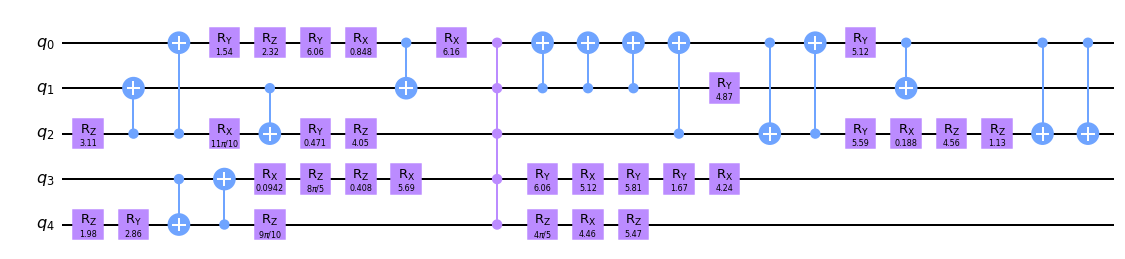

In [3]:
from circuits import create_circ

full_circuit=create_circ(upper_qubits, lower_qubits, 
                        gate_num, seed, measure_all=False, instance='Full')
full_circuit.draw('mpl')

Calling the function with *instance*='No_controll' returns the same circuit (as long as the seed is the same) without the multi-control gate.
This can be used for verification of the method to make sure that the expectation of an observable (chosen later) is very different with respect to the same circuit without MCZ gate. To guarantee that the MCZ gate strongly influences the outcome, the number of gates typically has to be chosen quite large (e.g. 50).

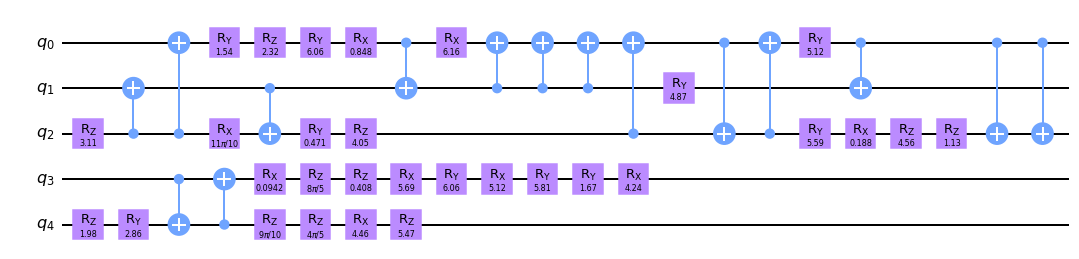

In [4]:
circuit_noControl=create_circ(upper_qubits, lower_qubits, gate_num, seed,
                        measure_all=False, instance='No_control')
circuit_noControl.draw('mpl')

We now define the observable to measure. We choose a Z-Pauli string on all qubits. Below, we define that observable for the upper and lower part of the circuit. The function `obervable` creates the numpy matrix of the observable in matrix representation.

In [5]:
from utilities import observable, expectation

O_u=observable(upper_qubits)
O_b=observable(lower_qubits)

The figure below shows the required circuits to be evaluated with labels in red. We also load these circuits by the function `create_circ`. 

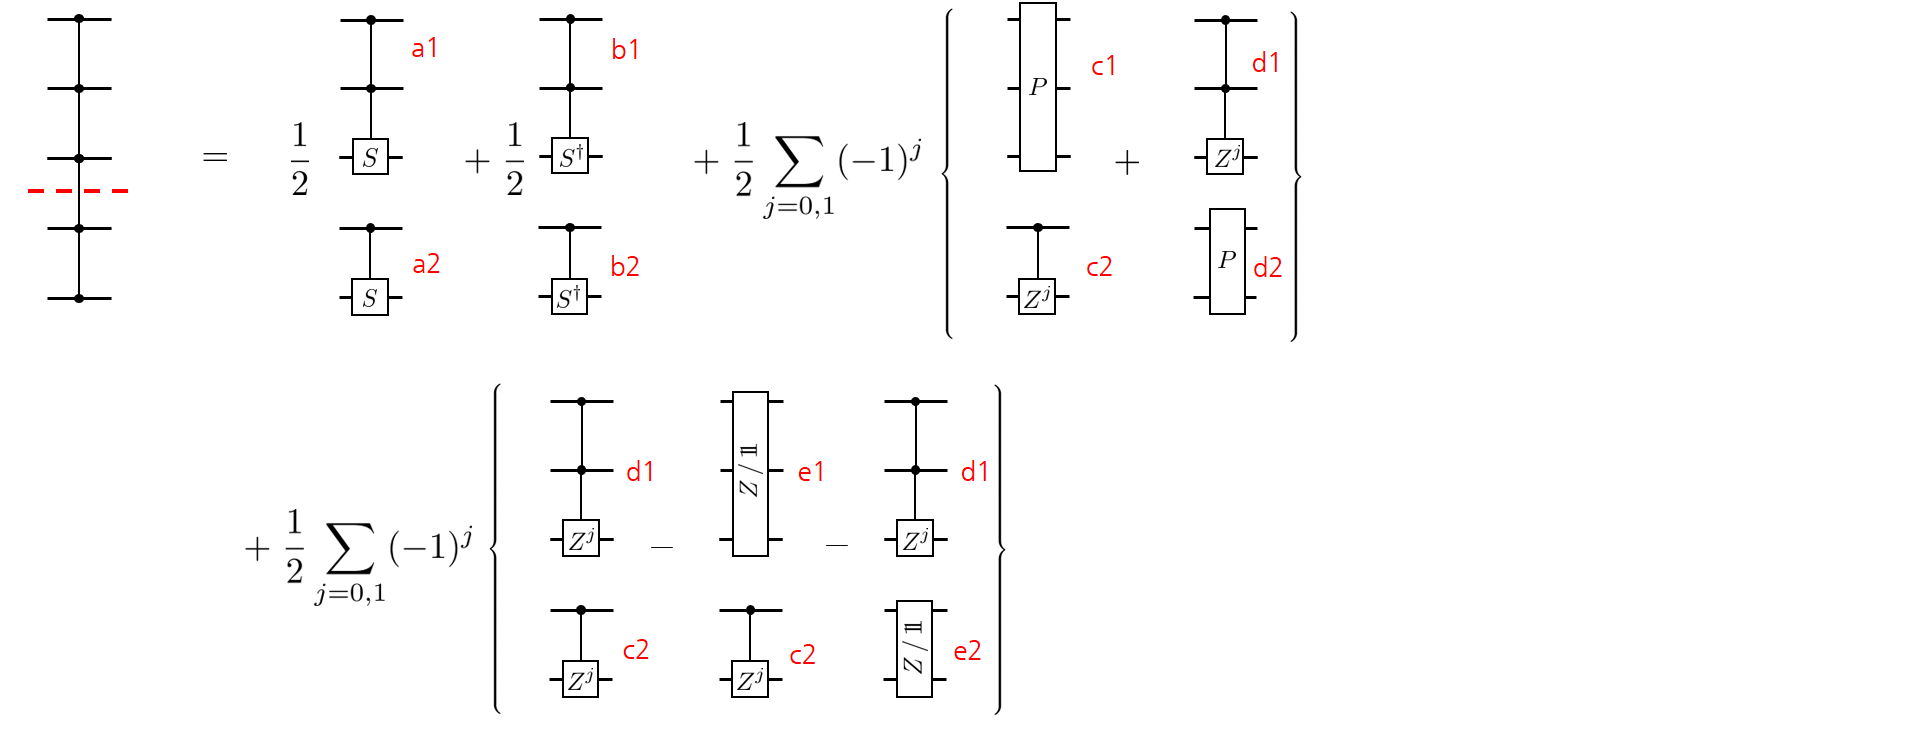

Recall that 
 - the Z/11 gate stands for all combinations of Z gates on the qubits divided by 2***n_qubits*. The implementation used here does not take into account that some of the prefactors of some of the gates can be subtracted from each other, which would lead to smaller sampling overhead. Obviously, e.g. when *upper_qubits*=1 and *lower_qubit*=1, the multi-control gate reduces to a CZ gate, the gates in the second line would cancel but are still evaluated here. 
 - the P operation stands for an intermediate measurement in the computational basis where the result is weighted by a minus sign only if the all-one state is observed. 
 -the letters in red label the circuit instances and correspond to the strings *instance* to be passed to the function.
 -The controlled Z gates can be called by *instance*='c2_j' and *instance*='d1_1' with j=1 or j=0
 -Note that *instance*='e1' and *instance*='e2' return a list of the corresponding circuits.


For example we can call the a1 circuit as:

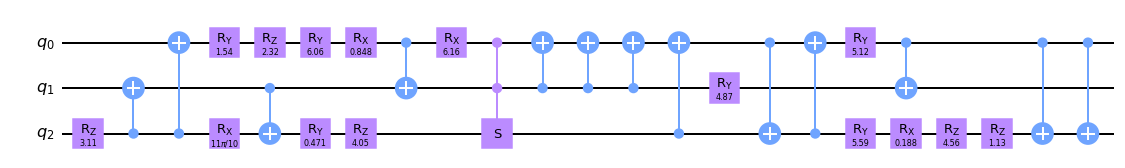

In [6]:
from utilities import evaluateCircuit

a1=create_circ(upper_qubits, lower_qubits, gate_num, seed,
                        measure_all=False, instance='a1')
a1.draw('mpl')

We now load all the required circuits. 

In [7]:
measure_all=False

Full=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='Full')
No_control=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='No_control')

a1=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='a1')
a2=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='a2')
b1=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='b1')
b2=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='b2')
c2_0=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='c2_0')
c2_1=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='c2_1')
d1_0=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='d1_0')
d1_1=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='d1_1')
# e1 and e2 are lists of circuits
e1=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='e1')
e2=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='e2')
# c1 and d2 is a list of circuits [upper/lower left part, upper_lower right part]
c1=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='c1')
d2=create_circ(upper_qubits, lower_qubits, gate_num, seed,measure_all, instance='d2')

No we evaluate all the circuits to get the states and probabilities for the measurements.

In [8]:
s_Full=evaluateCircuit(Full, intermediate_measurement=False)
s_No_control=evaluateCircuit(No_control, intermediate_measurement=False)

s_a1=evaluateCircuit(a1, intermediate_measurement=False)
s_a2=evaluateCircuit(a2, intermediate_measurement=False)
s_b1=evaluateCircuit(b1, intermediate_measurement=False)
s_b2=evaluateCircuit(b2, intermediate_measurement=False)
s_c2_0=evaluateCircuit(c2_0, intermediate_measurement=False)
s_c2_1=evaluateCircuit(c2_1, intermediate_measurement=False)
s_d1_0=evaluateCircuit(d1_0, intermediate_measurement=False)
s_d1_1=evaluateCircuit(d1_1, intermediate_measurement=False)
# recall that e1 / e2 is a list of several circuits
e1_list=[]
e2_list=[]
for circ in e1:
    e1_list.append(evaluateCircuit(circ, intermediate_measurement=False))
s_e1=e1_list
for circ in e2:
    e2_list.append(evaluateCircuit(circ, intermediate_measurement=False))
s_e2=e2_list

s_c1=evaluateCircuit(c1, intermediate_measurement=True)
s_d2=evaluateCircuit(d2, intermediate_measurement=True)

We now calculate the expectation value of the observable with respect to full circuit
and with respect to the full circuit without the multi-control gate. Note the un-intuitive
ordering of the observables in the Kronecker product due to Qiskit's qubit ordering
Then we evaluate all circuits of the upper part and then those of the lower part.

In [9]:
e_full=expectation(np.kron(O_b, O_u),s_Full)
e_no_control=expectation(np.kron(O_b, O_u),s_No_control )

# First evaluate upper part of circuit.
e_a1=expectation(O_u,s_a1)
e_b1=expectation(O_u,s_b1)
e_d1_0=expectation(O_u,s_d1_0)
e_d1_1=expectation(O_u,s_d1_1)
# We already add the results for the Z/11 part of the circuits.
e_e1=np.sum(np.array([expectation(O_u,s) for s in s_e1]))

# For the intermediate measurement part, we have to weight the results with
# the probabilities of observing a bit string in the intermediate measurement.
# If we observe the all-one state, we have to add a minus sign.
e_c1=0
for index, val in enumerate(s_c1):
    p, s=val
    if index==len(s_c1)-1:
        e_c1+=-p*expectation(O_u,s)
    else:
        e_c1+=p*expectation(O_u,s)

            
# Second we calculatethe lower part of the circuit.
e_a2=expectation(O_b,s_a2)
e_b2=expectation(O_b,s_b2)
e_c2_0=expectation(O_b,s_c2_0)
e_c2_1=expectation(O_b,s_c2_1)
# We already add the results for the Z/11 part of the circuits.
e_e2=np.sum(np.array([expectation(O_b,s) for s in s_e2]))

# For the intermediate measurement part we have to weight the results with
# the probabilities of observing a bit string in the intermediate measurement.
# If we observe the all-one state, we have to put a minus sign
e_d2=0
for index, val in enumerate(s_d2):
    p, s=val
    if index==len(s_d2)-1:
        e_d2+=-p*expectation(O_b,s)
    else:
        e_d2+=p*expectation(O_b,s)

Finally, we put everything together...

In [10]:
Part1=1/2*e_a1*e_a2  +  1/2*e_b1*e_b2  +  1/2*e_c1*(e_c2_0-e_c2_1)  +  1/2*(e_d1_0-e_d1_1)*e_d2
Part2=1/2*(e_d1_0*e_c2_0-e_d1_1*e_c2_1)
Part2+=-1/2*e_e1*(e_c2_0-e_c2_1)/2**upper_qubits  -  1/2*e_e2*(e_d1_0-e_d1_1)/2**lower_qubits

...and output the result with respect to the original circuit, the cut circuit and the circuit without the MCZ gate.

In [11]:
print('exact: ', np.real(e_full)) # np.real only for better readability of the output.
print('decomposition: ', np.real(Part1+Part2))
print('without MC-gate: ', np.real(e_no_control))

exact:  0.09387750915295295
decomposition:  0.09387750915295327
without MC-gate:  -0.11717977188902434
